## Hard Drive Failure Prediction in the Data Center


### Classification of Hard Drive Status n-Days Prior to Failure

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
import ast
import itertools
import seaborn as sns
from functools import partial
from imblearn.under_sampling import RandomUnderSampler
from funcs_hrddrv import nboxplot, sctrmtrx, catbar

import dask
import dask.dataframe as dd
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, space_eval
from sklearn import metrics
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['xtick.top'] = True
# plt.rcParams['ytick.right'] = True
# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['ytick.left'] = True

In [2]:
filelist = glob.glob(os.getcwd() + f'/data/p1_proc/*.csv')
filelist.sort()

with open('columns_select.txt', 'r') as f:
    cols = ast.literal_eval(f.read())
features = [c for c in cols if 'smart' in c]

dtypes = {}
dtypes['serial_number'] = 'string'
dtypes['model'] = 'string'
if 'capacity_bytes' in cols: dtypes['capacity_bytes'] = 'float' 
dtypes['failure'] = 'int'
dtypes['failure_date'] = 'object'
dtypes['time_to_failure'] = 'float'
dtypes['category'] = 'int'
dtypes.update({smart:'float' for smart in [c for c in cols if 'smart' in c]})

df = dd.concat([dd.read_csv(f, dtype=dtypes, parse_dates=['date', 'failure_date']) for f in filelist])
df.head()

,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_199_raw,smart_241_raw,smart_242_raw,failure_date,time_to_failure,category
0,2019-01-15,ZCH0CHT9,ST12000NM0007,0,219010250.0,4.0,0.0,242985377.0,377.083333,3.0,...,30.0,103.0,505.0,0.0,0.0,5.028254e+10,1.037452e+11,NaT,99999.0,3
1,2019-01-15,ZCH08P1R,ST12000NM0007,0,115422360.0,2.0,0.0,214319704.0,359.916667,1.0,...,28.0,119.0,610.0,0.0,0.0,4.720373e+10,7.400561e+10,NaT,99999.0,3
2,2019-01-15,ZCH06FX1,ST12000NM0007,0,158731520.0,2.0,0.0,538424549.0,444.208333,1.0,...,30.0,107.0,526.0,0.0,0.0,5.531850e+10,1.318521e+11,NaT,99999.0,3
3,2019-01-15,ZCH07E02,ST12000NM0007,0,204049360.0,3.0,0.0,94681323.0,432.000000,2.0,...,39.0,175.0,718.0,0.0,0.0,5.249663e+10,8.222903e+10,NaT,99999.0,3
4,2019-01-15,ZJV136WP,ST12000NM0007,0,226557040.0,3.0,0.0,257016250.0,90.833333,3.0,...,28.0,24.0,917.0,0.0,0.0,1.922293e+10,2.250764e+10,NaT,99999.0,3


### Resampling

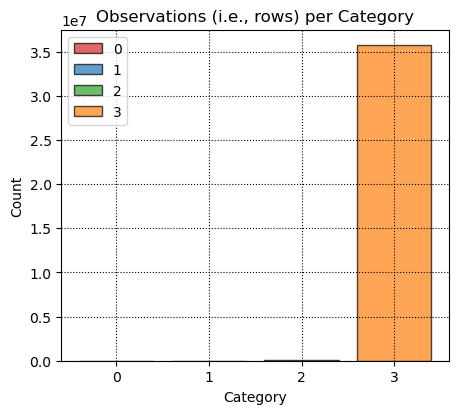

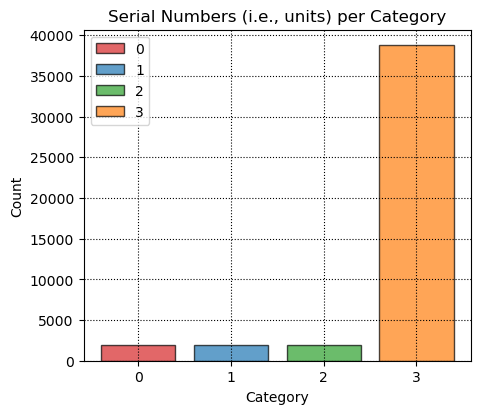

In [3]:
a = df[['category']].compute().value_counts().sort_index()
catbar(a, 'Observations (i.e., rows) per Category')

b = df[['category', 'serial_number']].groupby('category')['serial_number'].nunique().compute().sort_index()
catbar(b, 'Serial Numbers (i.e., units) per Category')

In [4]:
# resample serial numbers based on failed or not failed
sn_failed = df.loc[df['category'] < 3]['serial_number'].unique().compute()
sn_not_failed = df.loc[~df['serial_number'].isin(sn_failed)]['serial_number'].unique().compute()
sn_not_failed = sn_not_failed.sample(n=len(sn_failed), random_state=0)
sn_resample = list(set(sn_failed)) + list(set(sn_not_failed))

df = df.loc[df['serial_number'].isin(sn_resample)].compute()

# random down sample based on category
X = df.drop(columns='category').values
y = df['category'].values
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)

df = pd.DataFrame(X, columns=df.drop(columns='category').columns)
df['category'] = y

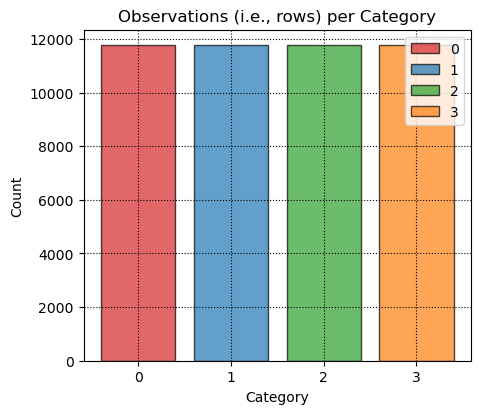

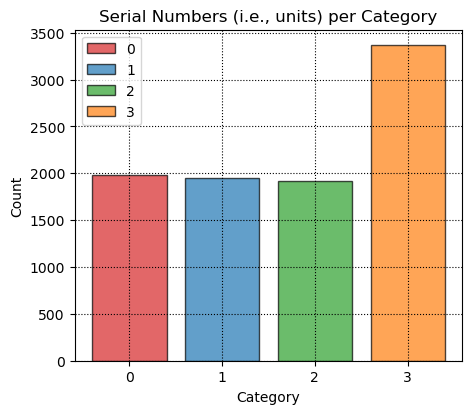

In [5]:
a = df[['category']].value_counts().sort_index()
catbar(a, 'Observations (i.e., rows) per Category')

b = df[['category', 'serial_number']].groupby('category')['serial_number'].nunique().sort_index()
catbar(b, 'Serial Numbers (i.e., units) per Category')

### Modeling

In [6]:
fit_models = {}

X = df[features].values
y = df['category'].values

# scale
ss = StandardScaler()
Xscaled = ss.fit_transform(X)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xscaled, y, test_size=0.25, shuffle=True, random_state=0)

df_scaled = pd.DataFrame(Xscaled, columns=features)
df_scaled['category'] = y

In [7]:
def box_compare(df, features):
    
    df = df.melt(id_vars=['category'], var_name='Feature', value_name='Distribution')

    plt.figure(figsize=(17, 4))

    ax = sns.boxplot(
                data=df,
                x="Feature", 
                y="Distribution",
                hue="category", 
                palette=['tab:red', 'tab:blue', 'tab:green', 'tab:orange'],
                notch=False, 
                showfliers=True,
                flierprops={"marker": "o"},
               )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.87, 1), ncol=4, title=None)
    ax.set_ylim(-3, 3)
    plt.xticks(rotation=60)
    plt.title('Feature Distributions for Categories 1-4 ')
    plt.show()

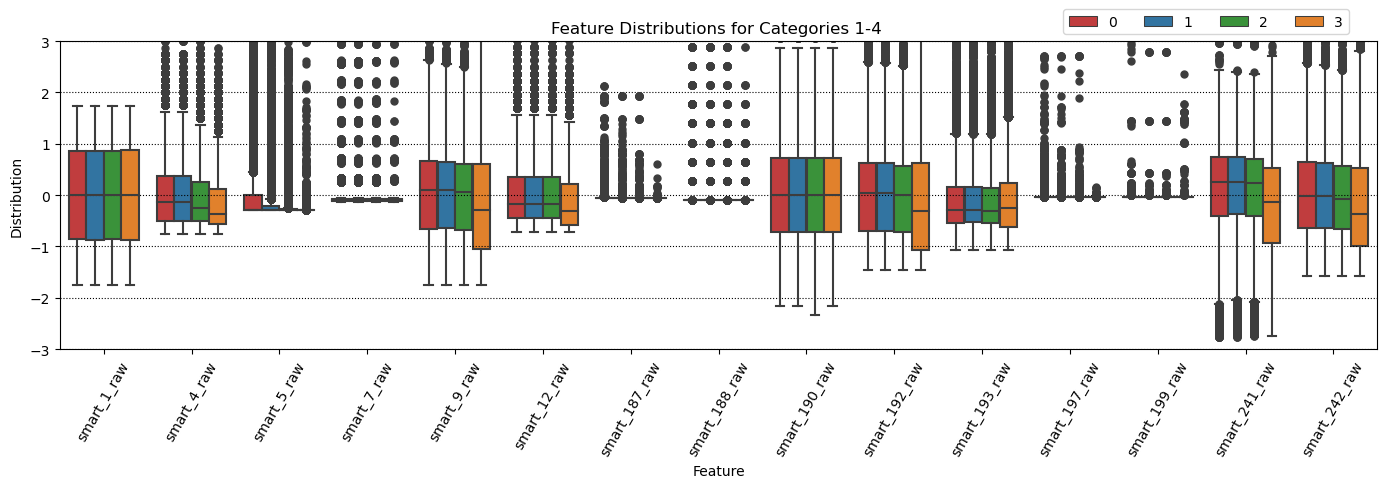

In [8]:
box_compare(df=df_scaled, features=features)

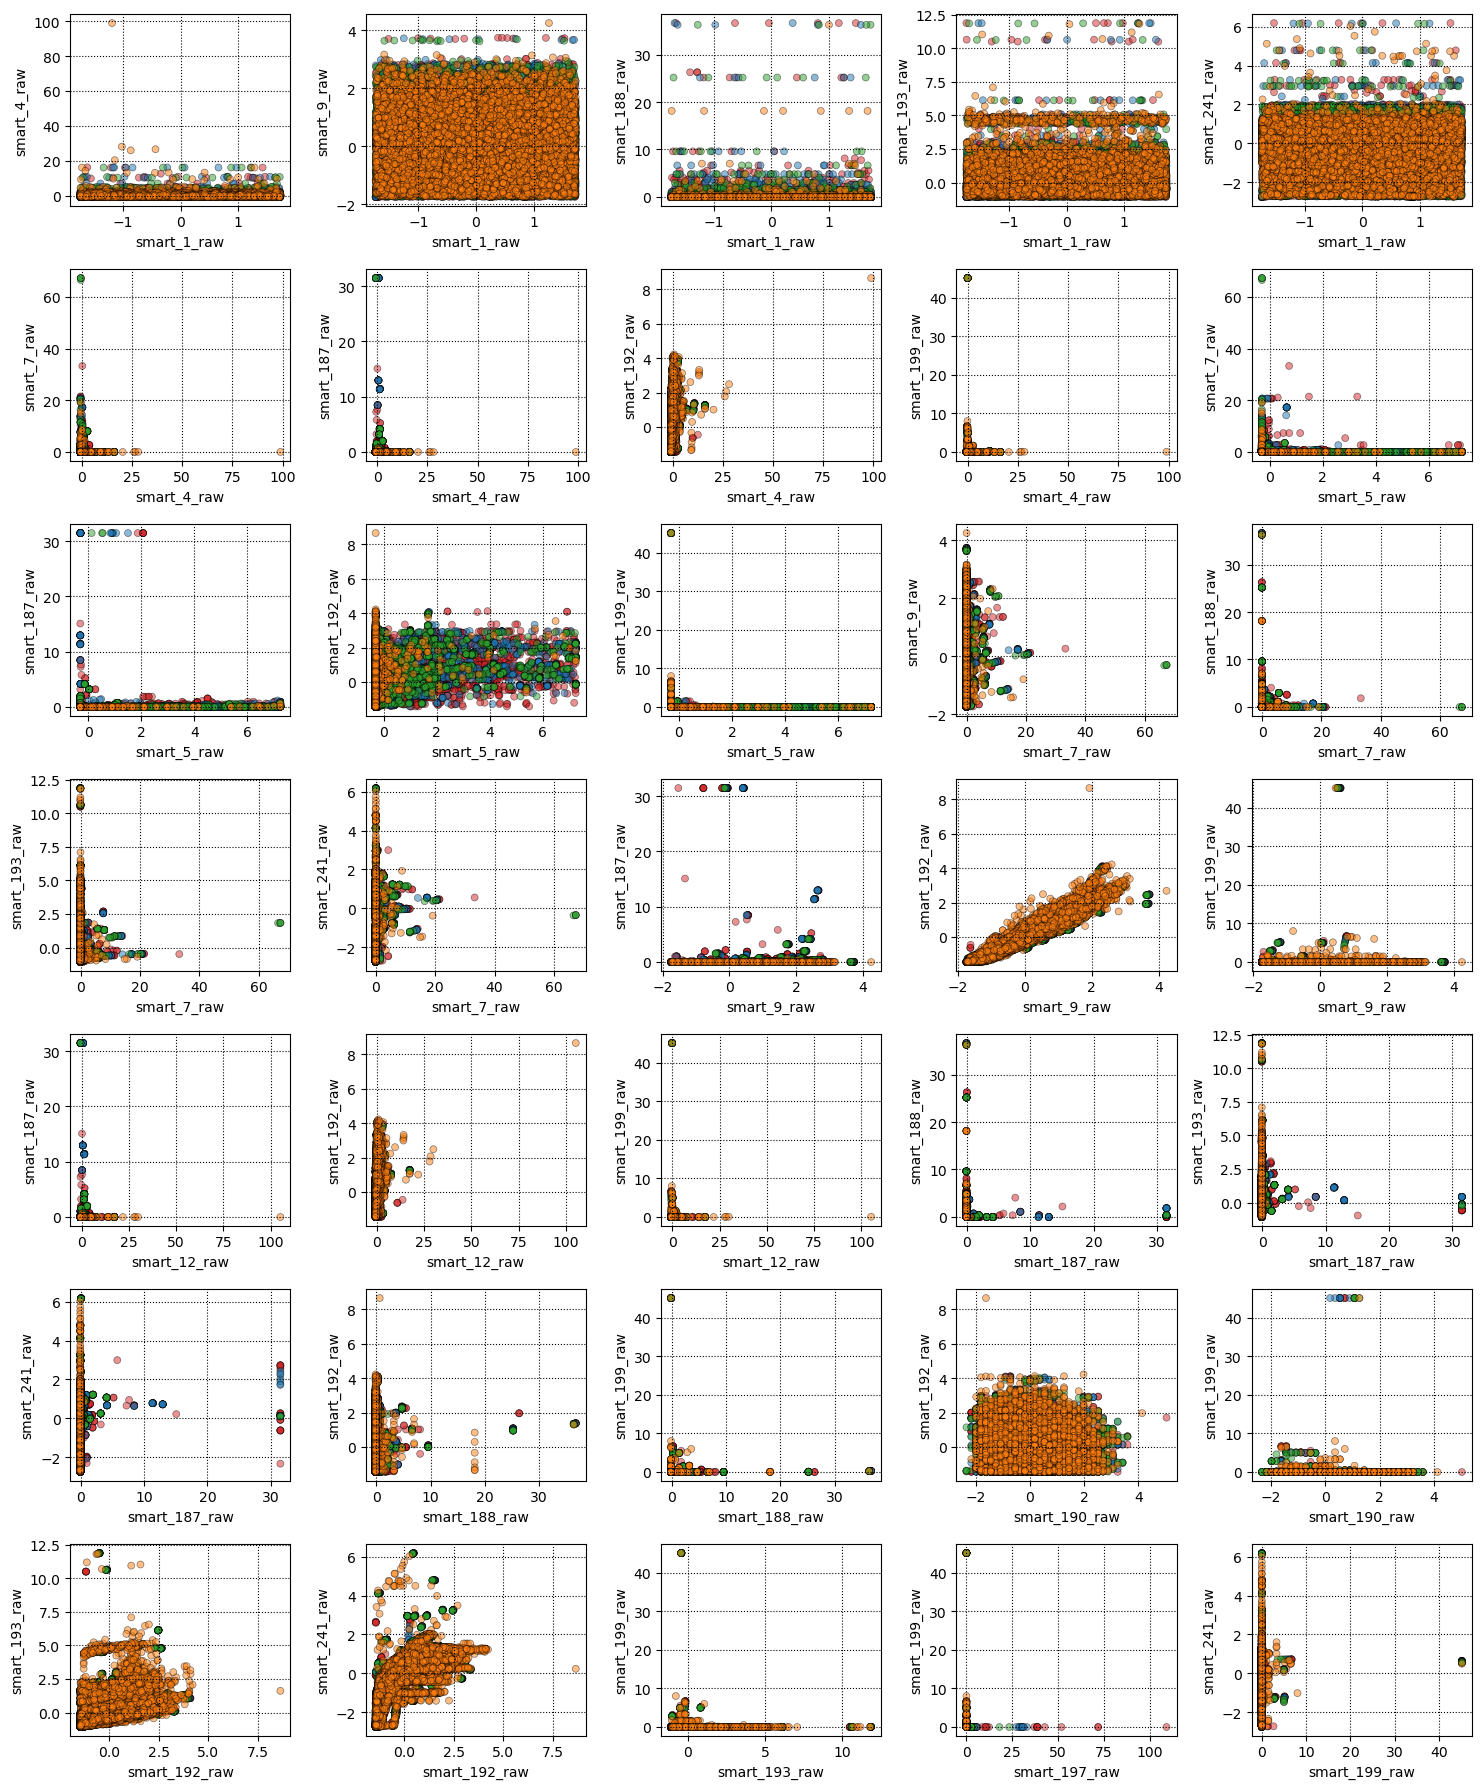

In [9]:
pairs = features
pairs = list(itertools.combinations(pairs, 2))
sctrmtrx(df=df_scaled, pairs=pairs[::3], m=7, n=5)

In [10]:
# objective function
def objective(params, estimator, X, y):
    """
    Define objective function for hyperopt hyperparameter tuning.
    params: parameter space to search.
    estimator: model to be tuned.
    X: explanatory variables.
    y: target variable.
    
    """
    
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    
    score = cross_val_score(estimator=estimator(**params), 
                            X=X, 
                            y=y, 
                            cv=kfold, 
                            scoring='accuracy', 
                            n_jobs=-1).mean()

    # Loss is negative score
    loss = - score

    # Dictionary with information for evaluation
    return {'loss':loss, 'params':params, 'status':STATUS_OK}

In [11]:
rftest = {n:RandomForestClassifier(n_estimators=n, random_state=0, oob_score=True, n_jobs=-1).fit(X=Xtrain, y=ytrain).oob_score_ for n in np.arange(0, 3000, 100)[1:]}
rftest = pd.DataFrame.from_dict(rftest, orient='index')

exttest = {n:ExtraTreesClassifier(n_estimators=n, random_state=0, bootstrap=True, oob_score=True, n_jobs=-1).fit(X=Xtrain, y=ytrain).oob_score_ for n in np.arange(0, 3000, 100)[1:]}
exttest = pd.DataFrame.from_dict(exttest ,orient='index')

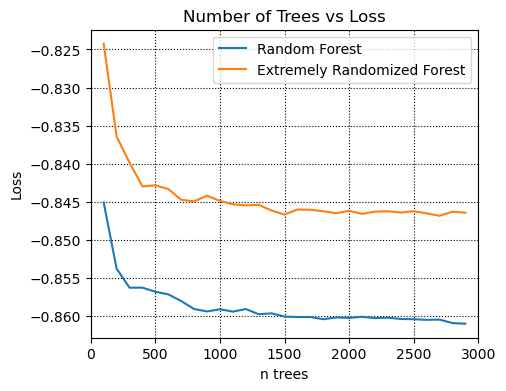

In [12]:
plt.figure(figsize=(5, 4))
plt.plot(-rftest, color='tab:blue', label='Random Forest')
plt.plot(-exttest, color='tab:orange', label='Extremely Randomized Forest')
plt.title('Number of Trees vs Loss')
plt.legend()
plt.xlabel('n trees')
plt.ylabel('Loss')
plt.xlim(0, 3000)

plt.show()

In [13]:
space = {
        'n_estimators': hp.choice('n_estimators', [1500]),
        'min_samples_split':hp.choice('min_samples_split', np.arange(5, 30, 1)),
        'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(5, 30, 1)),           
        'max_features':hp.choice('max_features', np.arange(1, 10)),
        'random_state':hp.choice('random_state', [0]),
        }

# optimize
trials = Trials()
best = fmin(fn=partial(objective, estimator=RandomForestClassifier, X=Xtrain, y=ytrain), space=space, algo=tpe.suggest, max_evals=100, trials=trials)
best_params = space_eval(space, best)
print(best_params)

# fit 
fit_models['RF'] = RandomForestClassifier(**best_params).fit(X=Xtrain, y=ytrain)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:39:50<00:00, 95.90s/trial, best loss: -0.6786291351305384]
{'max_features': 7, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 1500, 'random_state': 0}


In [14]:
space = {
        'n_estimators': hp.choice('n_estimators', [1500]),
        'min_samples_split':hp.choice('min_samples_split', np.arange(5, 30, 1)),
        'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(5, 30, 1)),           
        'max_features':hp.choice('max_features', np.arange(1, len(features))),
        # 'bootstrap':hp.choice('bootstrap', [True])
        'random_state':hp.choice('random_state', [0]),
        }

# optimize
best = fmin(fn=partial(objective, estimator=ExtraTreesClassifier, X=Xtrain, y=ytrain), space=space, algo=tpe.suggest, max_evals=100, trials=Trials())
best_params = space_eval(space, best)
print(best_params)

# fit 
fit_models['EXT'] = ExtraTreesClassifier(**best_params).fit(X=Xtrain, y=ytrain)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [51:49<00:00, 31.09s/trial, best loss: -0.657680641777929]
{'max_features': 11, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1500, 'random_state': 0}


In [15]:
space = {
        'n_estimators': hp.choice('n_estimators', np.arange(10, 2000, 10)),
        'learning_rate': hp.choice('learning_rate', np.logspace(-3, 0, 100)),
        'min_samples_split':hp.choice('min_samples_split', np.arange(5, 30, 1)),
        'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(5, 30, 1)),           
        'max_depth':hp.choice('max_depth', np.arange(1, 10, 1)),
        'max_features':hp.choice('max_features', np.arange(1, len(features))),
        'random_state':hp.choice('random_state', [0]),
        }

# optimize
best = fmin(fn=partial(objective, estimator=GradientBoostingClassifier, X=Xtrain, y=ytrain), space=space, algo=tpe.suggest, max_evals=100, trials=Trials())
best_params = space_eval(space, best)
print(best_params)

# fit 
fit_models['GBM'] = GradientBoostingClassifier(**best_params).fit(X=Xtrain, y=ytrain)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [7:16:59<00:00, 262.20s/trial, best loss: -0.7738469824531564]
{'learning_rate': 0.6135907273413176, 'max_depth': 9, 'max_features': 13, 'min_samples_leaf': 5, 'min_samples_split': 23, 'n_estimators': 980, 'random_state': 0}


In [16]:
# Space
space = {
        'n_estimators': hp.choice('n_estimators', np.arange(10, 2000, 10)),
        'learning_rate': hp.choice('learning_rate', np.logspace(-3, 0, 100)),
        'max_depth':hp.choice('max_depth', np.arange(1, 10, 1)),
        'gamma':hp.choice('gamma', np.logspace(-2, 2, 100)),
        'colsample_bytree':hp.choice('colsample_bytree', np.logspace(-1, 0, 100)),     
        'reg_alpha':hp.choice('reg_alpha', np.logspace(-3, 2, 100)), 
        'reg_lambda':hp.choice('reg_lambda', np.logspace(-3, 2, 100)),
        'seed':hp.choice('seed', [0])
        }

# optimize
best = fmin(fn=partial(objective, estimator=XGBClassifier, X=Xtrain, y=ytrain), space=space, algo=tpe.suggest, max_evals=100, trials=Trials())
best_params = space_eval(space, best)
print(best_params)

# fit 
fit_models['XGB'] = XGBClassifier(**best_params).fit(X=Xtrain, y=ytrain)

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [1:22:19<00:55, 55.73s/trial, best loss: -0.7278113218244182]

/home/trent/miniconda3/envs/hrddrv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:22:27<00:00, 49.48s/trial, best loss: -0.7278113218244182]
{'colsample_bytree': 0.7564633275546291, 'gamma': 0.010974987654930561, 'learning_rate': 1.0, 'max_depth': 9, 'n_estimators': 1110, 'reg_alpha': 0.036783797718286326, 'reg_lambda': 2.420128264794381, 'seed': 0}


In [17]:
def feature_imp_plot(name, ensemble_model, features):
    """
    Feature importance plot for Random Forest or GBM.
    
    Parameters:
        name: Model name.
        ensemble_model: Model with feature_importances_ attribute.
        features: List of features corresponding to feature importances.
    """
    
    # feature importance
    ft_imp = pd.DataFrame(ensemble_model.feature_importances_)
    ft_imp.columns = ['Importance']
    ft_imp['Feature'] = features
    ft_imp = ft_imp.sort_values('Importance')

    cm = plt.cm.get_cmap('Reds')
    colors = [cm(val/len(features)) for val in range(len(features))]
    fig, ax = plt.subplots(figsize=(3, len(features) // 2))
    ax.barh(ft_imp['Feature'], ft_imp['Importance'], edgecolor='k', color=colors)
    ax.set_xlabel('Importance')
    ax.set_title(f'Feature Importance: {name}', size=12)
    plt.show()

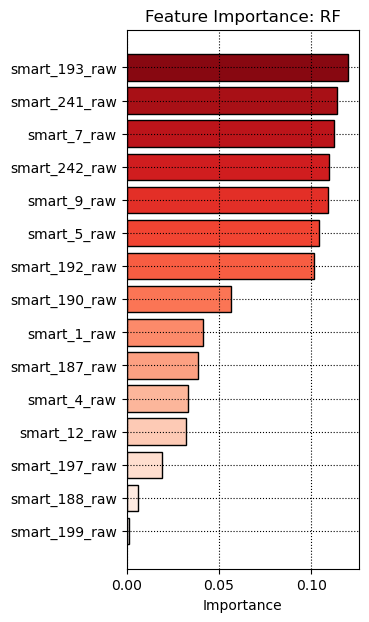

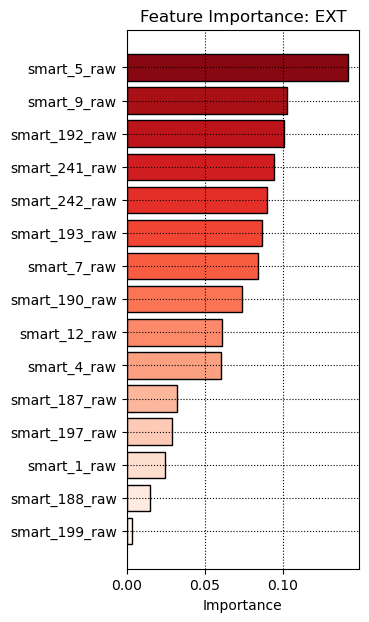

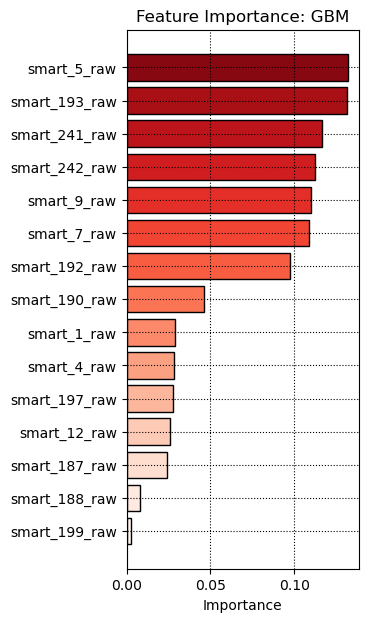

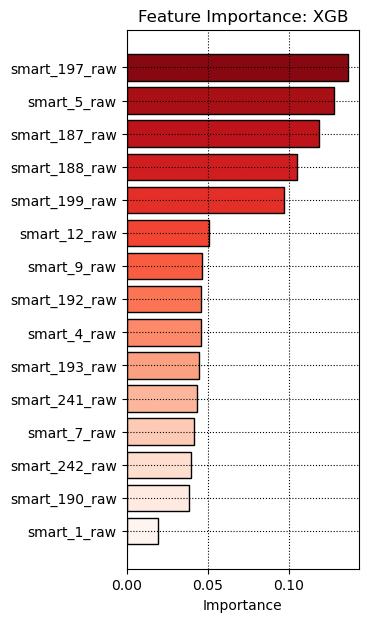

In [18]:
feature_imp_plot('RF', fit_models['RF'], features)
feature_imp_plot('EXT', fit_models['EXT'], features)
feature_imp_plot('GBM', fit_models['GBM'], features)
feature_imp_plot('XGB', fit_models['XGB'], features)

In [19]:
def prfm_rpt(fit_models, Xtest, Xtrain, ytest, ytrain):
    """
    Generate performance results.
    
    Parameters:
        fit_models: Models to generate performance results for.
        Xtest: Test data set.
        Xtrain: Train data set.
        ytest: Test target data set.

    Returns: 
        ypreds, train_pred_probs, test_pred_probs
    """
    
    # classification reports
    target_names = [
                    'Category 0', 
                    'Category 1', 
                    'Category 2', 
                    'Category 3',
                   ]
    acc_test = {}
    acc_train = {}
    ypreds = {}
    test_pred_probs = {}
    train_pred_probs = {}
    
    for m in fit_models:
        train_pred_probs[m] = fit_models[m].predict_proba(Xtrain)
        test_pred_probs[m] = fit_models[m].predict_proba(Xtest)
        ypreds[m] = fit_models[m].predict(Xtest)

    for m in fit_models:
        print(f'Classification Report for {m}')
        acc_test[m] = metrics.accuracy_score(ytest, ypreds[m])
        acc_train[m] = metrics.accuracy_score(ytrain, fit_models[m].predict(Xtrain))
        print(metrics.classification_report(ytest, ypreds[m], target_names=target_names))
        print('Test Accuracy:', round(acc_test[m], 3))
        print('Train Accuracy:', round(acc_train[m], 3), '\n')

        # conf_mat = metrics.confusion_matrix(y_true=ytest, y_pred=ypreds[m], labels=fit_models[m].classes_,)
        # print(conf_mat)
        # print('-----------------------------------------------------------', '\n')
        
    return ypreds, train_pred_probs, test_pred_probs

In [20]:
np.unique(ytest, return_counts=True) 

(array([0, 1, 2, 3]), array([2997, 2915, 2867, 2980]))

In [21]:
ypreds, train_pred_probs, test_pred_probs = prfm_rpt(
                    fit_models=fit_models,
                    Xtest=Xtest,
                    Xtrain=Xtrain,
                    ytest=ytest,
                    ytrain=ytrain
                    )

Classification Report for RF
              precision    recall  f1-score   support

  Category 0       0.81      0.82      0.81      2997
  Category 1       0.70      0.68      0.69      2915
  Category 2       0.77      0.76      0.76      2867
  Category 3       0.84      0.86      0.85      2980

    accuracy                           0.78     11759
   macro avg       0.78      0.78      0.78     11759
weighted avg       0.78      0.78      0.78     11759

Test Accuracy: 0.781
Train Accuracy: 0.955 

Classification Report for EXT
              precision    recall  f1-score   support

  Category 0       0.76      0.82      0.79      2997
  Category 1       0.67      0.60      0.63      2915
  Category 2       0.76      0.75      0.76      2867
  Category 3       0.86      0.89      0.87      2980

    accuracy                           0.77     11759
   macro avg       0.76      0.76      0.76     11759
weighted avg       0.76      0.77      0.76     11759

Test Accuracy: 0.766
Train

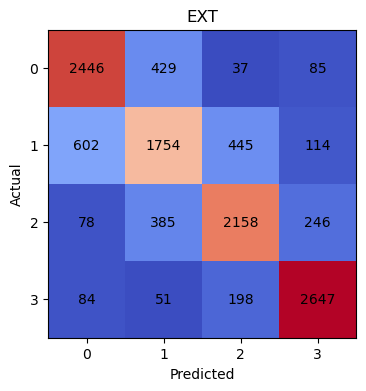

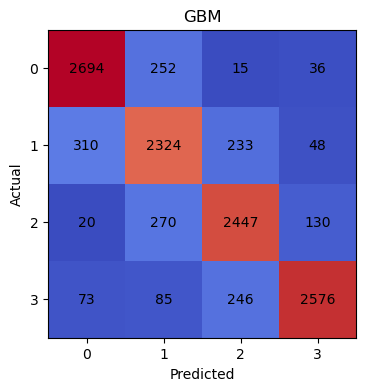

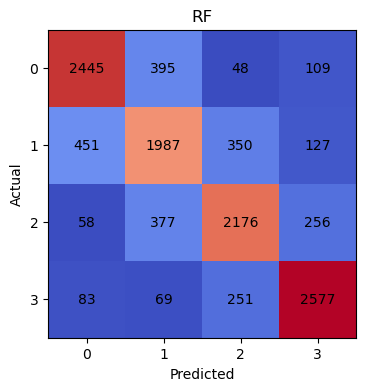

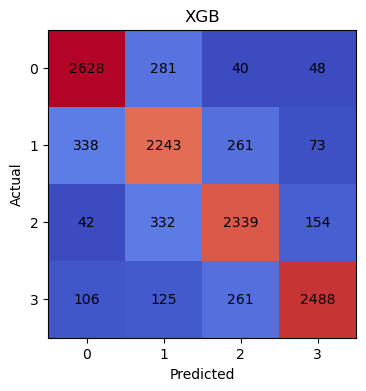

In [22]:
l = list(fit_models.keys())
l.sort()
for m in l:
    #print(m, '\n')
    conf_mat = metrics.confusion_matrix(y_true=ytest, y_pred=ypreds[m], labels=fit_models[m].classes_, normalize=None)

    fig, ax = plt.subplots(figsize=(5,4) )

    ax.matshow(conf_mat, cmap='coolwarm')
    for (i, j), z in np.ndenumerate(conf_mat):
        ax.text(j, i, f'{round(z, 3)}', ha='center', va='center',)

    ax.grid(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{m}', size=12)
    plt.show()

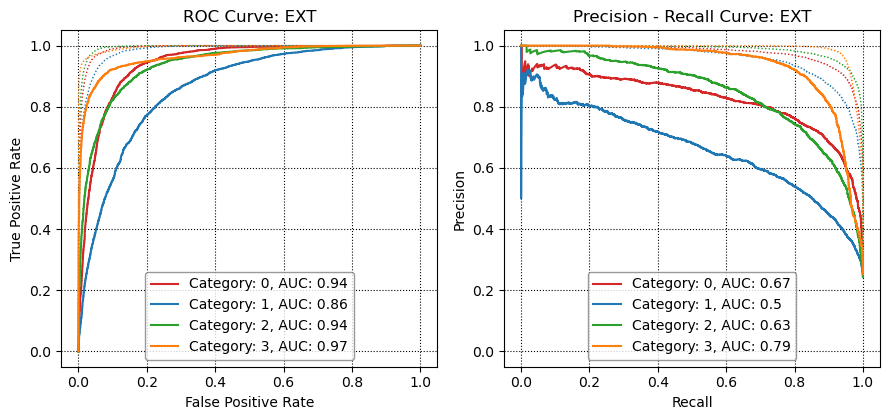

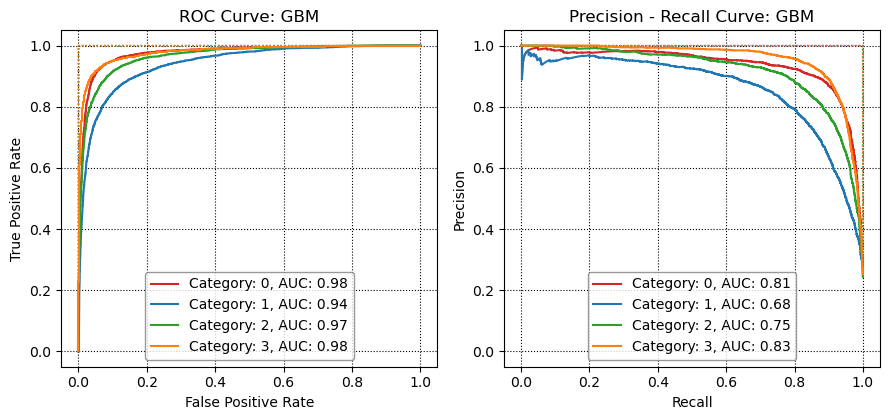

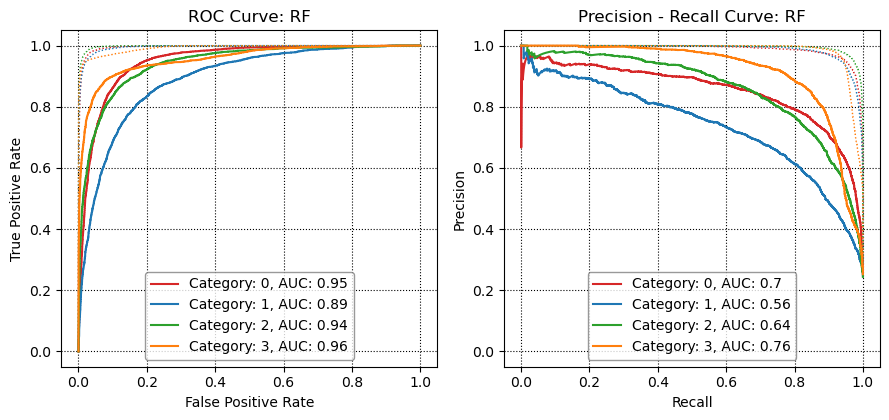

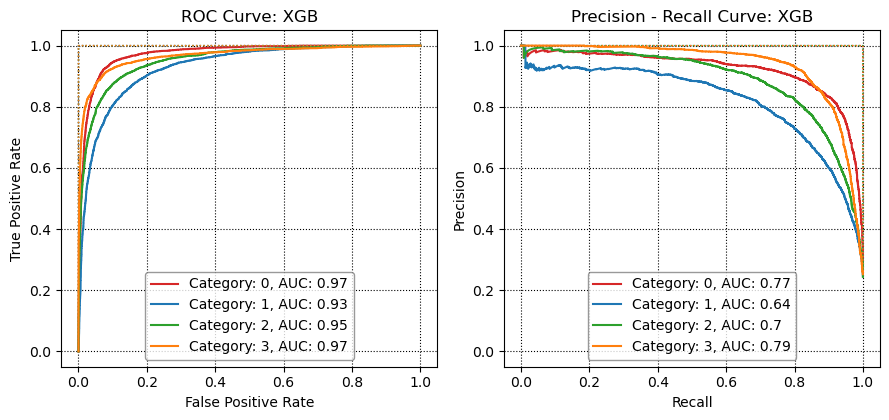

In [23]:
cmap = {0:'tab:red', 1:'tab:blue', 2:'tab:green', 3:'tab:orange'}
l = list(fit_models.keys())
l.sort()
for m in l:

    fig, ax = plt.subplots(1, 2, figsize=(9, 4.3))
    for category in [0, 1, 2, 3, ]:
        # Receiver operating characteristic (ROC)
        fpr_test, tpr_test, thresholds = metrics.roc_curve(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        rocauc = metrics.roc_auc_score(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        fpr_train, tpr_train, thresholds = metrics.roc_curve(np.where(ytrain == category, 1, 0), train_pred_probs[m][:, category])

        # plot ROC curve
        ax[0].plot(fpr_test, tpr_test, c=cmap[category], linewidth=1.5, label=f'Category: {category}, AUC: {round(rocauc, 2)}')
        ax[0].plot(fpr_train, tpr_train, linestyle=':', c=cmap[category], linewidth=1)
        ax[0].set_xlabel('False Positive Rate', )
        ax[0].set_ylabel('True Positive Rate', )
        ax[0].set_xlim(-0.05, 1.05)
        ax[0].set_ylim(-0.05, 1.05)
        ax[0].set_title('ROC Curve: '+ str(m), size=12)
        ax[0].legend(edgecolor='gray', facecolor='white', loc=8, fontsize=10)

        # precision recall
        precision_test, recall_test, thresholds = metrics.precision_recall_curve(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        PRauc = metrics.average_precision_score(np.where(ytest == category, 1, 0), np.where(ypreds[m] == category, 1, 0))
        precision_train, recall_train, thresholds = metrics.precision_recall_curve(np.where(ytrain == category, 1, 0), train_pred_probs[m][:, category])

        # plot precision recall curve
        ax[1].plot(recall_test, precision_test, c=cmap[category], linewidth=1.5, label=f'Category: {category}, AUC: {round(PRauc, 2)}')
        ax[1].plot(recall_train, precision_train, linestyle=':', c=cmap[category], linewidth=1)
        ax[1].set_xlabel('Recall', )
        ax[1].set_ylabel('Precision', )
        ax[1].set_xlim(-0.05, 1.05)
        ax[1].set_ylim(-0.05, 1.05)
        ax[1].set_title('Precision - Recall Curve: ' + str(m), size=12)
        ax[1].legend(edgecolor='gray', facecolor='white', loc=8, fontsize=10)
    plt.tight_layout()
#     plt.savefig(cwd + '/figures/ROC_PC_{}.png'.format(str(m).replace(' ', '_')))
    plt.show()

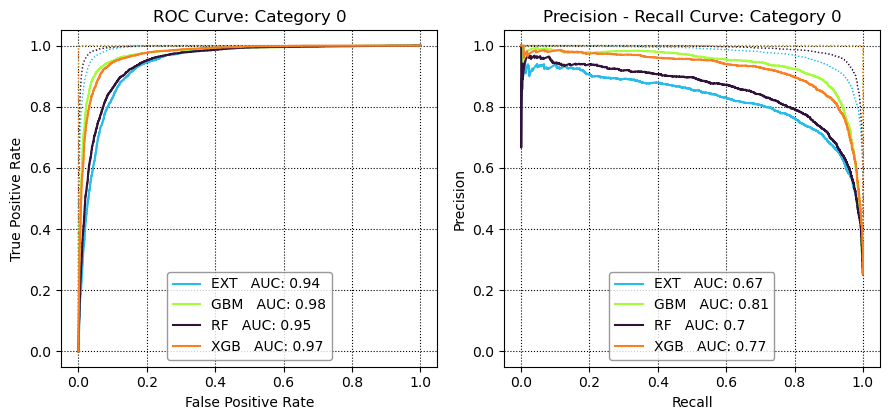

In [24]:
cm = plt.cm.get_cmap('turbo')
cmap = {m:cm(i/len(fit_models))  for i, m in enumerate(fit_models.keys())}
l = list(fit_models.keys())
l.sort()
for category in [0, ]:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.3))
    for m in l:
        # Receiver operating characteristic (ROC)
        fpr_test, tpr_test, thresholds = metrics.roc_curve(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        rocauc = metrics.roc_auc_score(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        fpr_train, tpr_train, thresholds = metrics.roc_curve(np.where(ytrain == category, 1, 0), train_pred_probs[m][:, category])

        # plot ROC curve
        ax[0].plot(fpr_test, tpr_test, c=cmap[m], linewidth=1.5, label=f'{m}   AUC: {round(rocauc, 2)}')
        ax[0].plot(fpr_train, tpr_train, linestyle=':', c=cmap[m], linewidth=1)
        ax[0].set_xlabel('False Positive Rate', )
        ax[0].set_ylabel('True Positive Rate', )
        ax[0].set_xlim(-0.05, 1.05)
        ax[0].set_ylim(-0.05, 1.05)
        ax[0].set_title('ROC Curve: Category 0', size=12)
        ax[0].legend(edgecolor='gray', facecolor='white', loc=8, fontsize=10)

        # precision recall
        precision_test, recall_test, thresholds = metrics.precision_recall_curve(np.where(ytest == category, 1, 0), test_pred_probs[m][:, category])
        PRauc = metrics.average_precision_score(np.where(ytest == category, 1, 0), np.where(ypreds[m] == category, 1, 0))
        precision_train, recall_train, thresholds = metrics.precision_recall_curve(np.where(ytrain == category, 1, 0), train_pred_probs[m][:, category])

        # plot precision recall curve
        ax[1].plot(recall_test, precision_test, c=cmap[m], linewidth=1.5, label=f'{m}   AUC: {round(PRauc, 2)}')
        ax[1].plot(recall_train, precision_train, linestyle=':', c=cmap[m], linewidth=1)
        ax[1].set_xlabel('Recall', )
        ax[1].set_ylabel('Precision', )
        ax[1].set_xlim(-0.05, 1.05)
        ax[1].set_ylim(-0.05, 1.05)
        ax[1].set_title('Precision - Recall Curve: Category 0', size=12)
        ax[1].legend(edgecolor='gray', facecolor='white', loc=8, fontsize=10)
    plt.tight_layout()
#     plt.savefig(cwd + '/figures/ROC_PC_{}.png'.format(str(m).replace(' ', '_')))
    plt.show()